# Encrypting and Decrypting text

Using Moby Dick text as the training corpus, build a character-level Markov model to encode and decode a snippet of text from *The Adventures of Sherlock Holmes*.

A **substitution cipher** is replacing each letter with another letter.

1) Generate a random substitution cipher - this will be only be used to encode a message. You can use it to decode a returning message, but in this exercise, we will attempt to decode the message using the Markov model.

2) Read in Moby Dick text to create character-level language model (unigrams and bigrams) that returns log likelihood of decrypted message
    * There are 26 letters in the alphabet, so there are 26 unigrams and 26<sup>2</sup> bigrams
    
3) Create encoding function that uses the 'true' substitution cipher

4) Create decoding function that uses an estimated substitution cipher

5) Run **genetic algorithm** in a For Loop to the maximum number of iterations needed to converge upon a maximum likelihood estimate. This is used to decrypt a hidden message.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import string
import random

# Regex library
import re

import requests

# Miscellaneous tasks
import os
import textwrap

%matplotlib inline

## Create random Substitution Cipher

In [2]:
# Two lists of letters - one will act as the key, the other as the cipher value
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}

# Shuffle second set of letters
random.shuffle(letters2)

# Populate true_mapping
for k, v in zip(letters1, letters2):
    true_mapping[k] = v

In [3]:
true_mapping

{'a': 'x',
 'b': 'y',
 'c': 'a',
 'd': 'r',
 'e': 't',
 'f': 'c',
 'g': 'w',
 'h': 'p',
 'i': 'm',
 'j': 'g',
 'k': 'n',
 'l': 'e',
 'm': 'f',
 'n': 'z',
 'o': 'h',
 'p': 'k',
 'q': 'b',
 'r': 'j',
 's': 'l',
 't': 'q',
 'u': 'd',
 'v': 'v',
 'w': 'i',
 'x': 'o',
 'y': 's',
 'z': 'u'}

In [4]:
# Conceptually, only the sender and receiver have the true mapping (substitution cipher)
# The person (you!) intercepting the message will use the genetic algorithm to decode the message

## Building the Language Model

Start by defining the structures that you need for your language, e.g. *A* and *pi* arrays and the functions to update them according the training corpus.

In [5]:
# Components to 'fit' the language model

# Initialize bigram Markov matrix - use add-one smoothing
M = np.ones((26, 26))

# Initial state distribution for starting letters
pi = np.zeros(26)


# Function to update the Markov matrix - input arguments are start and end characters, and output is count of characters
# ord() function converts chararacter to ascii number representation, e.g. ord('a') is 97, ..., ord('z') is 122
def update_transition(ch1, ch2):
    i = ord(ch1) - 97 
    j = ord(ch2) - 97 
    M[i,j] += 1
    

# Function to update the initial state distribution - input argument is initial character and output is count of character
def update_pi(ch):
    i = ord(ch) - 97 
    pi[i] += 1


In [20]:
### --------------------- THESE ARE TO BE USED IN THE GENETIC ALGORITHM ----------------------- ###


# Get the log-probability of a given word, which is then invoked to get probability of a sentence

def get_word_prob(word):
    # Index the first-occurring letter
    i = ord(word[0]) - 97 
    # Find its probability by indexing it in pi
    logp = np.log(pi[i]) 
    
    # Loop through remaining letters in word
    for ch in word[1:]:
        j = ord(ch) - 97 
        logp += np.log(M[i, j]) # Update probability by indexing characters in Markov matrix
        i = j # Update j 
        
    return logp


# Get the probability of a given sequence of words (sentence or list of multiple words)

def get_sequence_prob(words):
    
    # If input is a string, split into an array of tokens 
    if type(words) == str:
        words = words.split() 
        
    logp = 0 
    
    # Loop through each in word in sentence
    for word in words:
        # Update probability by finding probability for each word
        logp += get_word_prob(word)
        
    return logp

### Populate Markov and pi arrays ('train' the model)

The training corpus is based on an English version of 'Moby Dick' taken from https://www.gutenberg.org/ebooks/2701 (front and back matter removed). You can download the text file in the code below.
        
Using the Moby Dick text, you will populate your Markov matrix and initial pi state distribution.

In [6]:
if not os.path.exists('data/moby_dick.txt'):
    print("Downloading moby dick...") 
    r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt') 
    with open('data/moby_dick.txt', 'w', encoding='utf-8') as f:
        f.write(r.content.decode())

In [7]:
# Helps to replace non-alpha characters
regex = re.compile('[^a-zA-Z]')

# Load in lines by line
for line in open('data/moby_dick.txt', encoding='utf-8'):
    line = line.rstrip() 
    
    # Any blank lines should fail
    if line:
        line = regex.sub(' ', line) # Replace all non-alpha characters in line with space 
        
        # Split the words in the line and lowercase 
        tokens = line.lower().split() 
        
        # Update each word, i.e. populate arrays
        for token in tokens:
            # First letter 
            ch0 = token[0] 
            # Call function to input letter index and count in pi
            update_pi(ch0) 
            
            # Other letters 
            for ch1 in token[1:]:
                # Call function to input letter index and count in Markov matrix
                update_transition(ch0, ch1) 
                ch0 = ch1


In [8]:
# Calculate the probabilities in both M and pi arrays

pi /= pi.sum()

M /= M.sum(axis=1, keepdims=True)

In [9]:
# 26 dimensions (entire array adds up to one)
pi

array([1.09454034e-01, 5.20069678e-02, 3.89842666e-02, 2.71213123e-02,
       1.82485492e-02, 3.85045319e-02, 1.63296103e-02, 6.39397863e-02,
       6.72094345e-02, 3.90774189e-03, 4.42939516e-03, 2.83136627e-02,
       3.90727613e-02, 2.23239653e-02, 6.49737776e-02, 2.81599612e-02,
       3.33485482e-03, 1.80063530e-02, 9.26074280e-02, 1.64227627e-01,
       1.23054280e-02, 7.33574908e-03, 6.73817664e-02, 2.32880923e-05,
       1.16393885e-02, 1.58359028e-04])

In [10]:
# 26x26 dimensions (each nested array adds up to one)
M

array([[7.04046861e-05, 2.76127179e-02, 3.36111972e-02, 4.38621195e-02,
        4.22428117e-04, 8.73018108e-03, 2.05018446e-02, 1.08704835e-02,
        4.75090822e-02, 2.95699682e-04, 1.45456082e-02, 1.10633924e-01,
        2.53034442e-02, 2.09721479e-01, 2.11214058e-04, 2.34306795e-02,
        7.04046861e-05, 1.08395055e-01, 9.77076234e-02, 1.42217466e-01,
        7.92756766e-03, 2.33602749e-02, 1.04198935e-02, 4.50589991e-04,
        2.94854826e-02, 2.63313526e-03],
       [6.00292826e-02, 2.66089503e-02, 6.36577758e-05, 5.72919982e-04,
        2.54949392e-01, 6.36577758e-05, 1.27315552e-04, 4.45604431e-04,
        3.79400344e-02, 5.47456872e-03, 6.36577758e-05, 1.20567827e-01,
        8.91208861e-04, 1.27315552e-04, 1.52333057e-01, 6.36577758e-05,
        6.36577758e-05, 5.88197848e-02, 1.89063594e-02, 7.25698644e-03,
        1.67483608e-01, 8.27551085e-04, 1.27315552e-04, 6.36577758e-05,
        8.60653129e-02, 6.36577758e-05],
       [1.43763797e-01, 4.59896983e-05, 1.56364974e-02

### Encoding new text

You now have the Markov matrix and initial state distribution pi array populated with the probabilities of two letters given one previous letter, as well as the probability of being the first letter, based on Moby Dick. 

Using a random excerpt from Project Gutenberg's 'The Adventures of Sherlock Holmes', by Arthur Conan Doyle, you encode the text with the random substitution cipher created at the start, which is the `true_mapping` dictionary (text to encode taken from https://www.gutenberg.org/ebooks/1661).

NOTE: The excerpt is surrounded by three quotation marks to allow for the text to be formatted as it is in text file, but it will still be read by Python interpreter.

In [11]:
original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''


# OTHER PARAGRAPHS FROM SAME BOOK:

# Away they went, and I was just wondering whether I should not do well
# to follow them when up the lane came a neat little landau, the coachman
# with his coat only half-buttoned, and his tie under his ear, while all
# the tags of his harness were sticking out of the buckles. It hadn't
# pulled up before she shot out of the hall door and into it. I only
# caught a glimpse of her at the moment, but she was a lovely woman, with
# a face that a man might die for.

# My cabby drove fast. I don't think I ever drove faster, but the others
# were there before us. The cab and the landau with their steaming horses
# were in front of the door when I arrived. I paid the man and hurried
# into the church. There was not a soul there save the two whom I had
# followed and a surpliced clergyman, who seemed to be expostulating with
# them. They were all three standing in a knot in front of the altar. I
# lounged up the side aisle like any other idler who has dropped into a
# church. Suddenly, to my surprise, the three at the altar faced round to
# me, and Godfrey Norton came running as hard as he could towards me.

In [12]:
# Function to encode message by mapping letters with the random substitution cipher

def encode_message(msg):
    # Lower-case message
    msg = msg.lower() 
    
    # Replace non-alpha characters 
    msg = regex.sub(' ', msg) 
     
    coded_msg = [] 
    
    # Loop through each character in message
    for ch in msg:
        # Could be whitespace so keep as character
        coded_ch = ch 
        if ch in true_mapping:
            coded_ch = true_mapping[ch] 
            
        coded_msg.append(coded_ch)
            
    return ''.join(coded_msg)


encoded_message = encode_message(original_message)

In [13]:
# e.g. 'm' is meant to be 'i' and 't' is meant to be 'e'

encoded_message

'm qptz ehdzwtr rhiz qpt lqjttq xzr chdzr  xl m toktaqtr  qpxq qptjt ixl x ftil mz x exzt ipmap jdzl rhiz ys hzt ixee hc qpt wxjrtz  m etzq qpt hlqetjl x pxzr mz jdyymzw rhiz qptmj phjltl  xzr jtatmvtr mz toapxzwt qihktzat  x wexll hc pxec xzr pxec  qih cmeel hc lpxw qhyxaah  xzr xl fdap mzchjfxqmhz xl m ahder rtlmjt xyhdq fmll xretj  qh lxs zhqpmzw hc pxec x rhutz hqptj kthket mz qpt ztmwpyhdjphhr mz iphf m ixl zhq mz qpt etxlq mzqtjtlqtr  ydq iphlt ymhwjxkpmtl m ixl ahfkteetr qh emlqtz qh  '

In [14]:
# Function to decode a message - not to be used until we have estimated new substitution cipher, i.e. word_map

def decode_message(msg, word_map):
    decoded_msg = [] 
    
    for ch in msg:
        decoded_ch = ch
        if ch in word_map:
            decoded_ch = word_map[ch] 
            
        decoded_msg.append(decoded_ch) 
        
    return ''.join(decoded_msg)

### Create Genetic Algorithm

Also known as the 'evolutionary algorithm', this optimtization method will be used to decode the message. In terms of evolution, the letters of the alphabet (and/or punctuation) are the DNA from which we build words and sentences. The DNA pool refers to several variants of the English alphabet (lowercase) that have all been randomly shuffled, e.g. [['a', 'd', 'x', 't', ...], ['i', 'f', 'n', 'l', ...], ...].

In this model, you need a DNA pool containing random DNA strings, which are essentially several random substitution ciphers. Each DNA string acts like a parent from which evolves n-number of children. The 'offspring' is generated by randomly selecting two letters from the parent and swapping them round and evaluating the log likelihood. In this model, we will loop through each DNA string three times to produce three offspring, i.e. three variations of the original DNA string (created and stored using the `evolve_offspring` function). 

The DNA string that yields the highest word and sentence probabilities based on the language model trained by 'Moby Dick' is stored as `best_dna`, `best_map` and `best_score`.


In [15]:
# Create list of 20 alphabet strings (shuffled)

dna_pool = []

for _ in range(20):
    # One DNA is lower-case alphabet shuffled
    dna = list(string.ascii_lowercase) 
    random.shuffle(dna) 
    dna_pool.append(dna)

In [17]:
# 11th DNA string
dna_pool[10]

['m',
 'i',
 'x',
 'n',
 'v',
 'u',
 'k',
 'h',
 'r',
 'd',
 'e',
 'q',
 'y',
 'a',
 'p',
 's',
 'l',
 'c',
 'j',
 'g',
 'f',
 'w',
 't',
 'b',
 'z',
 'o']

In [18]:
# Function to create n-children from each DNA string in the pool, i.e. 3 variations of shuffled alphabet

def evolve_offspring(dna_pool, n_children):
    # Make n_children per offspring 
    offspring = [] 
    
    # Loop through each DNA string the same number of times as children
    for dna in dna_pool:
        for _ in range(n_children):
            copy = dna.copy() 
            # Randomly select two numbers between 0 and 25
            j = np.random.randint(len(copy)) 
            k = np.random.randint(len(copy)) 
            
            # Swap position of letters and append to offspring
            tmp = copy[j] 
            copy[j] = copy[k] 
            copy[k] = tmp 
            offspring.append(copy) 
            
    return offspring + dna_pool

In [21]:
### ------------------- MAIN LOOP TO RUN GENETIC ALGORITHM ------------------ ###
# 1000 iterations means 1000 generations of offspring to be evolved
# Need function evolve_offspring to create the children 
# Need function decode_message to decode text with new cipher
# Need function get_sequence_prob to find log likelihood of sentence in decoded text

num_iters = 1000
# Store average score at end of loop
scores = np.zeros(num_iters)
# Keep track of best DNA string
best_dna = None
# Keep track of best substitution cipher
best_map = None
# Set to minimum possible score, minus infinity
best_score = float('-inf')

for i in range(num_iters):
    if i > 0:
        # Get 3 offspring from each DNA string in pool
        dna_pool = evolve_offspring(dna_pool, 3)
        
    # Calculate score for each DNA string 
    dna2score = {} 
    for dna in dna_pool:
        # Populate map 
        current_map = {} 
        for k, v in zip(letters1, dna):
            current_map[k] = v 
            
        decoded_message = decode_message(encoded_message, current_map) 
        score = get_sequence_prob(decoded_message)
        
        # Store DNA as joined string to be a dict key and score as the value 
        dna2score[''.join(dna)] = score 
        
        # Record the best score so far 
        if score > best_score:
            best_dna = dna 
            best_map = current_map 
            best_score = score 
            
    # Average score for each generation (plot later) 
    scores[i] = np.mean(list(dna2score.values()))
    
    # Keep the best 5 dna and turn them back into list of single chars 
    sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True) 
    dna_pool = [list(k) for k, v in sorted_dna[:5]] 
    
    # Print iteration, current score and best score so far every 200 iterations (debugging)
    if i % 200 == 0:
        print("iteration no:", i, "current score:", scores[i], "best score so far:", best_score)

iteration no: 0 current score: -2113.8236067480607 best score so far: -1927.000990489332
iteration no: 200 current score: -1058.07948870164 best score so far: -978.9403621422695
iteration no: 400 current score: -1036.3740687626264 best score so far: -929.5902922650557
iteration no: 600 current score: -1018.6066696695509 best score so far: -929.5902922650557
iteration no: 800 current score: -1038.1665643624087 best score so far: -929.5902922650557


In [29]:
# Note that best score does not improve after 400 iterations

In [22]:
# Each DNA string is slightly different
sorted_dna

[('cjfulmqowrpsizxhtdyekvgabn', -929.5902922650557),
 ('czfulmjowrpsiqxhtdyekvgabn', -929.5902922650557),
 ('czfulmqowrpsijxhtdyekvgabn', -929.5902922650557),
 ('cqfulmzowrpsijxhtdyekvgabn', -929.5902922650557),
 ('cjfulmzowrpsiqxhtdyekvgabn', -929.5902922650557),
 ('ckfulmzowrpsijxhtdyeqvgabn', -940.3634389315447),
 ('czmulfjowrpsiqxhtdyekvgabn', -944.6863798591762),
 ('cqfulmzowrksijxhtdyepvgabn', -945.5915699299015),
 ('cjfurmzowlpsiqxhtdyekvgabn', -954.2357477323015),
 ('czfulmjowrpsiqxhtdgekvyabn', -962.7262201697359),
 ('cjfulsqowrpmizxhtdyekvgabn', -1000.2429288540709),
 ('czfuliqowrpsmjxhtdyekvgabn', -1047.2091612206857),
 ('czfulmqowtpsijxhrdyekvgabn', -1072.0234899753198),
 ('cqfulmzowrpjisxhtdyekvgabn', -1102.006261156753),
 ('cjfulmqowrhsizxptdyekvgabn', -1110.214795665224),
 ('cjfuemzowrpsiqxhtdylkvgabn', -1149.6506532236474),
 ('czfulmjowrpsiqnhtdyekvgabx', -1168.8832702120683),
 ('cjfulmtowrpsiqxhzdyekvgabn', -1188.113306189231),
 ('cjfulmqowrpsizhxtdyekvgabn', -1203.742

In [24]:
len(dna_pool)

5

In [30]:
best_dna

['c',
 'z',
 'f',
 'u',
 'l',
 'm',
 'q',
 'o',
 'w',
 'r',
 'p',
 's',
 'i',
 'j',
 'x',
 'h',
 't',
 'd',
 'y',
 'e',
 'k',
 'v',
 'g',
 'a',
 'b',
 'n']

In [31]:
best_map

{'a': 'c',
 'b': 'z',
 'c': 'f',
 'd': 'u',
 'e': 'l',
 'f': 'm',
 'g': 'q',
 'h': 'o',
 'i': 'w',
 'j': 'r',
 'k': 'p',
 'l': 's',
 'm': 'i',
 'n': 'j',
 'o': 'x',
 'p': 'h',
 'q': 't',
 'r': 'd',
 's': 'y',
 't': 'e',
 'u': 'k',
 'v': 'v',
 'w': 'g',
 'x': 'a',
 'y': 'b',
 'z': 'n'}

In [32]:
best_score

-929.5902922650557

In [33]:
# Use best map to decode the messsage
decoded_message = decode_message(encoded_message, best_map)

# Compare likelihoods between the true message and the decoded message
print("Log Likelihood of decoded message:", get_sequence_prob(decoded_message))
print("Log Likelihood of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))

# Which letters do not match to the true substitution cipher?
for true, v in true_mapping.items():
    pred = best_map[v] 
    
    if true != pred:
        print("true: %s, pred: %s" % (true, pred))

Log Likelihood of decoded message: -929.5902922650557
Log Likelihood of true message: -933.0312453751817
true: j, pred: q
true: k, pred: j
true: q, pred: z
true: z, pred: k


In [35]:
# Very good! Only 4 letters were mapped incorrectly, and 'oz' and 'ze' letters appear rarely
# The log likelihood of your cipher is slightly higher than the true cipher, interestingly - it should be lower

In [34]:
# Print final decoded message using textwrap (remember punctuation is removed in decoded message)

print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 i then lounged down the street and found  as i expected  that there
was a mews in a lane which runs down by one wall of the garden  i lent
the ostlers a hand in rubbing down their horses  and received in
exchange twopence  a glass of half and half  two fills of shag tobacco
and as much information as i could desire about miss adler  to say
nothing of half a doken other people in the neighbourhood in whom i
was not in the least interested  but whose biographies i was compelled
to listen to

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

In [36]:
# See the word 'doken' should be 'dozen' - your language model has no record of either word

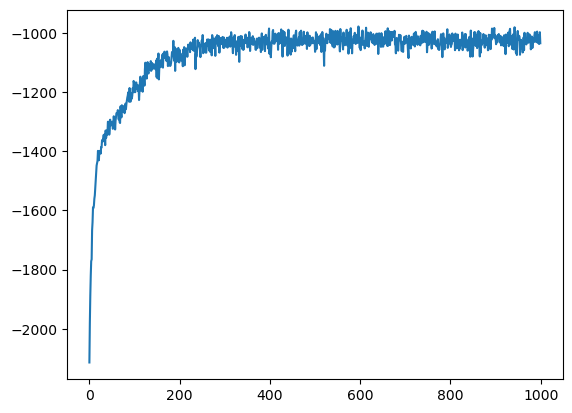

In [37]:
# Plot the scores per iteration - should improve quickly and then plateau as algorithm converges

plt.plot(scores);

In [ ]:
# This is a good indicator that you have used sufficient number of iterations (sanity check!)